# Google Cloud Platform - Using Machine Learning APIs  ).

This is an upgraded Python revision of [this notebook](https://github.com/GoogleCloudPlatform/training-data-analyst/blob/master/CPB100/lab4c/mlapis.ipynb).

This notebook originally was being processed using DataLab on the Google Cloud Platform.  This particular incarnation of the notebook is for running on Google Colaboratory which I am trying out for the first time.

### Security

First things first - we need to authenticate against the Google Cloud APIs.

#### Getting a Google API Credential.

First, visit <a href="http://console.cloud.google.com/apis">API console</a>, choose "Credentials" on the left-hand menu.  Choose "Create Credentials" and generate an API key for your application. You should probably restrict it by IP address to prevent abuse, but for now, just  leave that field blank and delete the API key after trying out this demo.

Then, when you have your key, you will enter it in this first executable cell:

In [0]:

'''
!pip install -q cloudstorage
!pip install -q webapp2
!pip install --upgrade numpy
!pip install six==1.10.0
!pip install -q datalab
!pip install --upgrade gcs-client
!pip install --upgrade google-cloud-storage
!pip install --upgrade google-api-python-client
!pip install opencv-python
!pip install gcsfs
'''

'\n!pip install -q cloudstorage\n!pip install -q webapp2\n!pip install --upgrade numpy\n!pip install six==1.10.0\n!pip install -q datalab\n!pip install --upgrade gcs-client\n!pip install --upgrade google-cloud-storage\n!pip install --upgrade google-api-python-client\n!pip install opencv-python\n!pip install gcsfs\n'

In [0]:
import getpass

APIKEY = getpass.getpass()

··········


In [2]:
import sys
import json
import argparse
import googleapiclient.discovery
import pandas as pd
import skimage.data
from skimage import img_as_float
import numpy as np
import pandas as pd
import os
import sys
import tensorflow as tf
import zipfile
import cv2

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image
%matplotlib inline
import io


import sys
import json
import argparse
import googleapiclient.discovery
import pandas as pd
import skimage.data
from skimage import img_as_float
import numpy as np
import pandas as pd
import os
import sys
import tensorflow as tf
import zipfile
import cv2

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image
%matplotlib inline
import io
from google.cloud import storage


import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import np_utils
from keras.datasets import mnist
from keras.callbacks import TensorBoard
from matplotlib import pyplot as plt
import matplotlib.image as mpimg


Using TensorFlow backend.


In [0]:
# Authenticate to GCS.
from google.colab import auth
auth.authenticate_user()

# Create the service client.
from googleapiclient.discovery import build
gcs_service = build('storage', 'v1')




In [0]:
BUCKET='wpiopenimageskaggle'
BUCKET_TUNE='mlclassifiertuning'

METHODS

In [0]:
def create_service():
    return googleapiclient.discovery.build('storage', 'v1')
def download_content(filename,bucket):
    from google.cloud import storage
    client = storage.Client('MLRobustClassifier')
    bucket = client.get_bucket(bucket)
    blob = storage.Blob(filename, bucket)
    content = blob.download_as_string()
    return(content)
def plot_image(filename):
  from google.cloud import storage
  client = storage.Client('MLRobustClassifier')
  bucket = client.get_bucket(BUCKET)
  blob = storage.Blob(filename, bucket)
  content = blob.download_as_string()
  img = Image.open(io.BytesIO(content))
  import matplotlib.pyplot as plt
  plt.imshow(img)
  plt.show()
def list_bucket_pf(bucket, pf):
    """Returns a list of metadata of the objects within the given bucket."""
    service = create_service()

    # Create a request to objects.list to retrieve a list of objects.
    fields_to_return = 'nextPageToken,items(name,size,contentType,metadata(my-key))'
    req = service.objects().list(bucket=bucket, fields=fields_to_return, prefix=pf)  # returns everything. UrbanSound is top dir in bucket

    all_objects = []
    # If you have too many items to list in one request, list_next() will
    # automatically handle paging with the pageToken.
    while req:
        resp = req.execute()
        all_objects.extend(resp.get('items', []))
        req = service.objects().list_next(req, resp)
    return all_objects
def process_image(filename, BUCKET):
  from google.cloud import storage
  client = storage.Client('MLRobustClassifier')
  bucket = client.get_bucket(BUCKET)
  blob = storage.Blob(filename, bucket)
  content = blob.download_as_string()
  img = Image.open(io.BytesIO(content)).convert('L')
  img=np.array(img)
  return(img)
def CreateDictLabels(Points):
    dictOfLabels = {}
    for point in Points:
        labelkey = point['annotations'][0]['label'] #get the label
        if labelkey not in dictOfLabels:
            dictOfLabels.setdefault(labelkey, [])
        dictOfLabels[labelkey].append(point['id'])
    return dictOfLabels
def CreateBatchOfImages(batchSize, labelDict, bucket,imageInputPath):
    #global imageInputPath
    ImageLabelDict = {}
    SuccessNum = 0
    for index in range(batchSize):
        for labelkey in labelDict.keys():
            if labelkey not in ImageLabelDict:
                ImageLabelDict.setdefault(labelkey, [])

            #force add one image, keep trying until one has been added, protects against corrupted images
            while len(labelDict[labelkey]) != 0 and  len(labelDict[labelkey]) <2000:
                try:
                    imageId = labelDict[labelkey].pop(0)
                    uriInp = imageInputPath + imageId + ".jpg"
                    if index%50==0:
                      print(index)
                    '''
                    with _open_file_read_binary(uriInp) as f:
                        image_bytes = f.read()
                        img = Image.open(io.BytesIO(image_bytes))
                    '''

                    #img= imageio.imread(uriInp)
                        #img = Image.open(io.BytesIO(image_bytes))
                    imgArr =  process_image(uriInp,bucket)
                except: #find image exception error for better style
                    continue
                else:
                    ImageLabelDict[labelkey].append([imgArr, imageId])
                    break
        #make sure all have nonzero number of images left
 
        SuccessNum += 1
    return ImageLabelDict, labelDict, SuccessNum

# IMPORT txt

In [0]:
from google.colab import files
uploaded = files.upload()
file='PointAnnotationsSet256x256.txt'
points = json.loads(uploaded[file].decode('utf-8'))

Saving PointAnnotationsSet256x256.txt to PointAnnotationsSet256x256 (4).txt


In [0]:
from google.colab import files
uploaded = files.upload()
tuning_images='tuning_images256x256.csv'
tuning_labels='tuning_labels.csv'
tuning_points='PointAnnotationsSet_Tuning.txt'
points_tune = json.loads(uploaded[tuning_points].decode('utf-8'))

Saving PointAnnotationsSet_Tuning.txt to PointAnnotationsSet_Tuning (4).txt


In [0]:
#IMPORT DATA
classes=[]
IdsFromLabels = CreateDictLabels(points)
idsToRemoveFromEachBatch = IdsFromLabels.copy()
for val in IdsFromLabels.items():
  print(len(val[1]))
  classes.append(val[0])
  


17473
2148
1460
4554
6021
892
544
633


In [0]:
imageInputPathTrain='Imagefiles256x256/'
ImageLabelDict, idsToRemoveFromEachBatch, SuccessNum = CreateBatchOfImages(10000, idsToRemoveFromEachBatch, BUCKET,imageInputPathTrain)

0
0
0
0
50
50
50
50
100
100
100
100
150
150
150
150
200
200
200
200
250
250
250
250
300
300
300
300
350
350
350
350
400
400
400
400
450
450
450
500
500
500
550
550
600
600
650
650
700
700
750
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350


In [0]:
#IMPORT DATA
IdsFromLabels_tune = CreateDictLabels(points_tune)
idsToRemoveFromEachBatch_tune = IdsFromLabels_tune.copy()
remove=[]
for val in IdsFromLabels_tune.items():
  if val[0] not in classes:
    remove.append(val[0])
for val in remove:  
  del IdsFromLabels_tune[val]
  
tuning_class=[]
for val in IdsFromLabels_tune.items():
  tuning_class.append(val[0])


In [0]:
 test='Imagefiles256x256/63424f32615631752b33383d.jpg'
 result=process_image(test, BUCKET_TUNE)
print(result)

[[121 121 121 ... 192 192 192]
 [121 121 121 ... 191 192 192]
 [121 121 121 ... 191 191 192]
 ...
 [149 127 116 ... 184 110  72]
 [147 140 124 ... 178 130  79]
 [126 151 147 ... 158 134  84]]


In [0]:
imageInputPathTrain='Imagefiles256x256/'
idsToRemoveFromEachBatch_tune = IdsFromLabels_tune.copy()

ImageLabelDict_tune, idsToRemoveFromEachBatch_tune, SuccessNum = CreateBatchOfImages(100, idsToRemoveFromEachBatch_tune, BUCKET_TUNE,imageInputPathTrain)

0
0
0
0
0
50
50


In [0]:

'''
##USE THIS WHEN SPLITTING THE TRAINING FOR TEST/TRAIN
keys=list(ImageLabelDict.keys())
data=[]
labels=[]
label=0
for val in keys:
  imgs=ImageLabelDict.get(val)
  for img in imgs:
        vec=img[0]
        data.append(vec)
        labels.append(label)
  label+=1
        
    ########
    ##
    ##Split data intro training and testing wtih 0.75 train vs 0.25 test
    ########
        
total=len(data)
train_size=round(total*0.75)
test_size=total-train_size
import random
random.seed(4)



train_ind=np.random.choice(len(labels),train_size,replace=False)
test_ind=np.setdiff1d(list(range(0, total)),train_ind)


labels_test=np.array(labels)
data_test=np.array(data)
    
X_train=data_test[np.where(train_ind)]
X_test=data_test[np.where(test_ind)]
Y_train=labels_test[np.where(train_ind)]
Y_test=labels_test[np.where(test_ind)]

img_len=256
img_width=256
# We reshape the input data to have a depth of 1 (grey scale)
if keras.backend.image_data_format() == 'channels_first':
        X_train = X_train.reshape(X_train.shape[0], 1, img_len, img_width)
        X_test = X_test.reshape(X_test.shape[0], 1, img_len, img_width)
        input_shape = (1, img_len, img_width)
else:
        X_train = X_train.reshape(X_train.shape[0], img_len, img_width, 1)
        X_test = X_test.reshape(X_test.shape[0], img_len, img_width, 1)
        input_shape = (img_len, img_width, 1)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# Then we normalize it so that the values are between 0 and 1
X_train /= 255
X_test /= 255
'''

In [0]:
##USE THIS WHEN SPLITTING THE TRAINING FOR TEST/TRAIN
X_train=[]
X_test=[]
Y_train=[]
Y_test=[]



###CONVERT FORMAT OF TRAINING DATA
keys=list(ImageLabelDict.keys())
data=[]
labels=[]
label=0
for val in keys:
  imgs=ImageLabelDict.get(val)
  labels.append(val)
  for img in imgs:
        vec=img[0]
        X_train.append(vec)
        Y_train.append(label)
  label+=1

In [0]:
for val in tuning_class:
  imgs=ImageLabelDict_tune.get(val)
  for img in imgs:
      vec=img[0]
      X_test.append(vec)
      label=labels.index(val)
      Y_test.append(label)

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
1
1
7


In [0]:
img_len=256
img_width=256

X_train=np.array(X_train)
Y_train=np.array(Y_train)
X_test=np.array(X_test)
Y_test=np.array(Y_test)

# We reshape the input data to have a depth of 1 (grey scale)
if keras.backend.image_data_format() == 'channels_first':
        X_train = X_train.reshape(X_train.shape[0], 1, img_len, img_width)
        X_test = X_test.reshape(X_test.shape[0], 1, img_len, img_width)
        input_shape = (1, img_len, img_width)
else:
        X_train = X_train.reshape(X_train.shape[0], img_len, img_width, 1)
        X_test = X_test.reshape(X_test.shape[0], img_len, img_width, 1)
        input_shape = (img_len, img_width, 1)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# Then we normalize it so that the values are between 0 and 1
X_train /= 255
X_test /= 255

In [0]:
   # Defining the model
    model = Sequential()
    model.add(Conv2D(32, 3, 3, activation='relu', input_shape=(img_len, img_width, 1)))
    # 32 is the number of convolutional filters to use. Frist 3 is the number of rows in each convolution kernel and second 3 is the number of columns in each kernel.


    model.add(Conv2D(32, 3, 3, activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    # MaxPooling2D is a way to reduce the number of parameters in our model by sliding a 2x2 pooling filter across the previous layer and taking the max of the 4 values in the 2x2 filter.

    model.add(Dropout(0.25))
    # Dropout regularizes the model and prevents overfitting

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax'))
    # Final layer has the output size of 10 to correspond to the number of classes

    model.summary()
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    # Fit model to training data
    model.fit(X_train, Y_train, batch_size=32, epochs=10, verbose=1)

    # Evaluate the model on test data
    score = model.evaluate(X_test, Y_test, verbose=0)
    print("test loss:", score[0])
    print("test accuracy:",  score[1])
    # score[0] gives you the test loss and score[1] gives you the accuracy

    tbCallBack = TensorBoard(log_dir='./log', histogram_freq=1, write_graph=True, write_grads=True, batch_size=32, write_images=True)

    # We can use a call back to look into the internal state of the model during training
    model.fit(X_train, Y_train, batch_size=32, epochs=10, verbose=1, validation_data=(X_test, Y_test), callbacks=[tbCallBack])





/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), activation="relu", input_shape=(256, 256,...)`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), activation="relu")`
  


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 254, 254, 32)      320       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 252, 252, 32)      9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 126, 126, 32)      0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 126, 126, 32)      0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 508032)            0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               65028224  
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
__________

In [0]:
print(len(Y_test))
print(np.unique(Y_test))
print(np.unique(Y_train))
x_

767
[2]
[2 5 6]


In [0]:
Y_train=pd.DataFrame(Y_train)
pd.value_counts(Y_train[0])

2    1000
5     892
6     409
Name: 0, dtype: int64

This code block is used to import and review results from models

In [0]:
def import_results(results):
  ###process results data and transform into df
  imageid=[]
  correct_label=[]
  predicted_label=[]
  num_res=len(results)
  print(num_res)
  for inst in results:
    keys=list(inst.keys())
    ### APPEND IMAGEID
    imageid_i=inst.get('id')
    imageid.append(imageid_i)
    ### APPEND CORRECT LABEL
    res=inst.get('correctIndicies')
    res=res[0]
    correct_label.append(res)
    ### APPEND PREDICATED LABEL
    res=inst.get('PredictLabels')
    res=res[0]
    ind=0
    prob=0
    for i in range(0,len(res)):
      if float(res[i])>prob:
        ind=i
        prob=res[i]
    predicted_label.append(ind)
  return(imageid,correct_label, predicted_label)
   
  

In [0]:
def process_results(imageid,correct_label,predicted_label):
  img_cnt=len(imageid)
  df=pd.DataFrame()
  df['imageid']=imageid
  df['true_label']=correct_label
  df['predicted_label']=predicted_label
  df['correct']=df['predicted_label']==df['true_label']
  correct=df[df.correct == True].shape[0]

  trueVdred=df.groupby(['true_label','predicted_label']).count()
  AccuracyByLabel=df.groupby(['true_label','correct']).count()
  
  return(img_cnt,correct,trueVdred,AccuracyByLabel)

In [56]:
from google.colab import files
uploaded = files.upload()

Saving EdgeResultsSubset_LabelPredict.txt to EdgeResultsSubset_LabelPredict (1).txt
Saving FImgSub_LabelPredict.txt to FImgSub_LabelPredict (1).txt
Saving EdgeTune_IdlabelPredict.txt to EdgeTune_IdlabelPredict (1).txt
Saving FImageTune_IdlabelPredict.txt to FImageTune_IdlabelPredict (1).txt
Saving sharpenmini_IdlabelPredict.txt to sharpenmini_IdlabelPredict.txt


In [0]:

fImg256predict='FImgSub_LabelPredict.txt'
results_fImg_256 = json.loads(uploaded[fImg256predict].decode('utf-8'))
edge256predict='EdgeResultsSubset_LabelPredict.txt'
results_edge_256 = json.loads(uploaded[edge256predict].decode('utf-8'))
edge256predict_tune='EdgeTune_IdlabelPredict.txt'
results_edge_256_tune = json.loads(uploaded[edge256predict_tune].decode('utf-8'))
fImg256predict_tune='FImageTune_IdlabelPredict.txt'
results_fImg_256_tune = json.loads(uploaded[fImg256predict_tune].decode('utf-8'))
sharp='sharpenmini_IdlabelPredict.txt'
results_sharp_tune = json.loads(uploaded[sharp].decode('utf-8'))


In [7]:
imageid,correct_label, predicted_label=import_results(results_fImg_256_tune)
img_cnt_ft,correct_ft,trueVdred_ft,AccuracyByLabel_ft=process_results(imageid,correct_label, predicted_label)
print(correct_ft/img_cnt_ft)

403
0.4143920595533499


In [8]:
imageid,correct_label, predicted_label=import_results(results_edge_256_tune)
img_cnt_et,correct_et,trueVdred_et,AccuracyByLabel_et=process_results(imageid,correct_label, predicted_label)
print(correct_et/img_cnt_et)

403
0.37965260545905705


In [9]:
imageid,correct_label, predicted_label=import_results(results_edge_256)
img_cnt_es,correct_es,trueVdred_es,AccuracyByLabel_es=process_results(imageid,correct_label, predicted_label)
print(correct_es/img_cnt_es)

3669
0.7307168165712729


In [10]:
imageid,correct_label, predicted_label=import_results(results_fImg_256 )
img_cnt_fs,correct_fs,trueVdred_fs,AccuracyByLabel_fs=process_results(imageid,correct_label, predicted_label)
print(correct_fs/img_cnt_fs)

3669
0.7228127555192151


In [58]:
imageid,correct_label, predicted_label=import_results(results_sharp_tune)
img_cnt_fs,correct_fs,trueVdred_fs,AccuracyByLabel_fs=process_results(imageid,correct_label, predicted_label)
print(correct_fs/img_cnt_fs)

403
0.22084367245657568


In [0]:
print("Accuracy by Method")
print('Train/Test Split')
print('Full Image')
print(correct_fs/img_cnt_fs)
print('Edge Image')
print(correct_es/img_cnt_es)
print('Train/Tune Split')
print('Full Image')
print(correct_ft/img_cnt_ft)
print('Edge Image')
print(correct_et/img_cnt_et)

Accuracy by Method
Train/Test Split
Full Image
0.7228127555192151
Edge Image
0.7307168165712729
Train/Tune Split
Full Image
0.4143920595533499
Edge Image
0.37965260545905705


In [0]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix



def cm_analysis(y_true, y_pred, labels, title, ymap=None, figsize=(10,10)):
  
    """
    CODE SOURCE:https://gist.github.com/shaypal5/94c53d765083101efc0240d776a23823
    
    """
    """
    Generate matrix plot of confusion matrix with pretty annotations.
    The plot image is saved to disk.
    args: 
      y_true:    true label of the data, with shape (nsamples,)
      y_pred:    prediction of the data, with shape (nsamples,)
      filename:  filename of figure file to save
      labels:    string array, name the order of class labels in the confusion matrix.
                 use `clf.classes_` if using scikit-learn models.
                 with shape (nclass,).
      ymap:      dict: any -> string, length == nclass.
                 if not None, map the labels & ys to more understandable strings.
                 Caution: original y_true, y_pred and labels must align.
      figsize:   the size of the figure plotted.
    """
    if ymap is not None:
        y_pred = [ymap[yi] for yi in y_pred]
        y_true = [ymap[yi] for yi in y_true]
        labels = [ymap[yi] for yi in labels]
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=labels, columns=labels)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    ax.set_title(title)
    sns.heatmap(cm, annot=annot, fmt='', ax=ax,cmap="Blues",annot_kws={"size": 14})

In [0]:
str_labels=["Person", "Table", "Tree", "Building", "Glasses", "Boat", "Insect", "Dog"]

3669


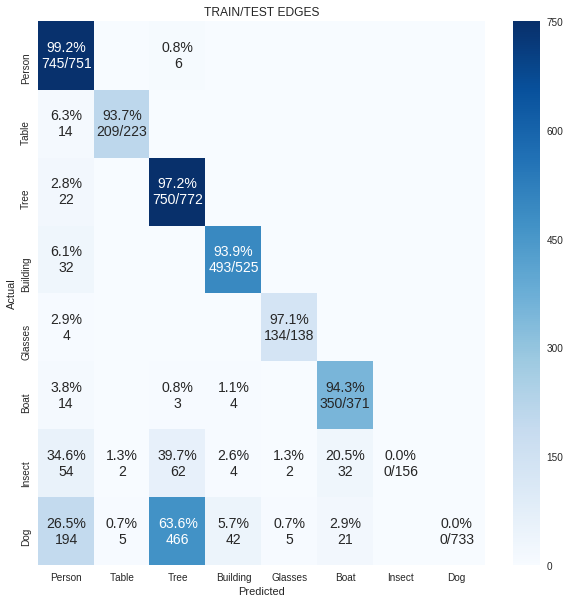

In [52]:
imageid,correct_label, predicted_label=import_results(results_edge_256)
y_true=[]
y_pred=[]
for val in correct_label:
  y_true.append(str_labels[val])
  
for val in predicted_label:
  y_pred.append(str_labels[val])
  
cm_analysis(y_true, y_pred, str_labels,'TRAIN/TEST EDGES' ,ymap=None, figsize=(10,10))

3669


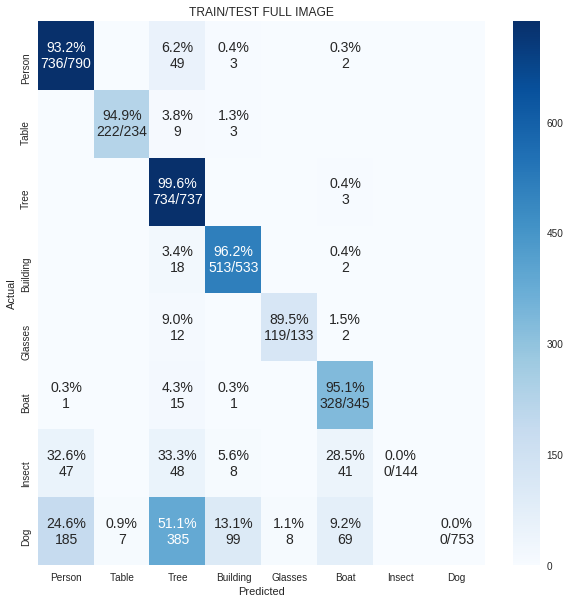

In [53]:
imageid,correct_label, predicted_label=import_results(results_fImg_256)
y_true=[]
y_pred=[]
for val in correct_label:
  y_true.append(str_labels[val])
  
for val in predicted_label:
  y_pred.append(str_labels[val])
  
cm_analysis(y_true, y_pred, str_labels,'TRAIN/TEST FULL IMAGE'  ,ymap=None, figsize=(10,10))

403


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide


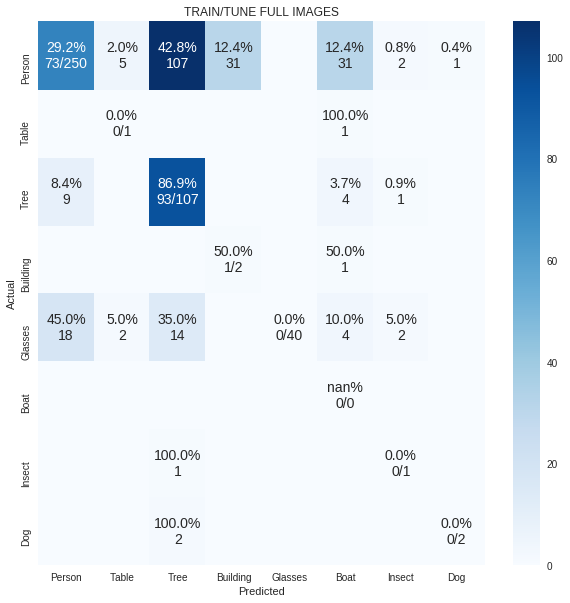

In [54]:
imageid,correct_label, predicted_label=import_results(results_fImg_256_tune)
y_true=[]
y_pred=[]
for val in correct_label:
  y_true.append(str_labels[val])
  
for val in predicted_label:
  y_pred.append(str_labels[val])
  
cm_analysis(y_true, y_pred, str_labels,'TRAIN/TUNE FULL IMAGES' , ymap=None, figsize=(10,10))

403


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide


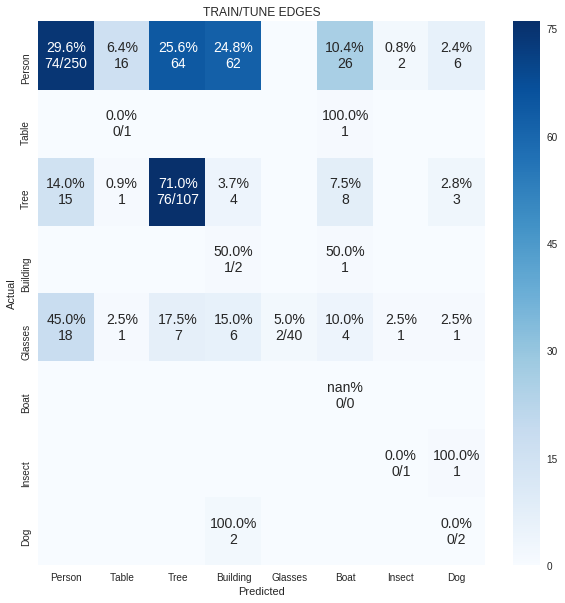

In [55]:
imageid,correct_label, predicted_label=import_results(results_edge_256_tune)
y_true=[]
y_pred=[]
for val in correct_label:
  y_true.append(str_labels[val])
  
for val in predicted_label:
  y_pred.append(str_labels[val])
  
cm_analysis(y_true, y_pred, str_labels,'TRAIN/TUNE EDGES' , ymap=None, figsize=(10,10))

***BELOW THIS POINT IS CODE TRIED THAT DOESN'T WORK KEPT FOR REFERENCE***